# Udemy网站课程数据的分析与可视化

## 数据来源
udemy_courses.csv：
Udemy在线学习网站上从2011年到2017年3678条课程的信息汇总表。
来自Kaggle：https://www.kaggle.com/andrewmvd/udemy-courses

## 目录
1. [摘要](#introduction)
2. [数据清洗](#paragraph1)
3. [九个参数的分析与可视化](#paragraph2)
    * [付费与免费课程分布情况](#subparagraph1)
    * [课程数随时间的变化](#subparagraph2)
    * [不同领域的课程分布情况](#subparagraph3)  
    * [不同难度的课程分布情况](#subparagraph4)
    * [价格分布情况](#subparagraph5)
    * [其他参数的分布情况](#subparagraph6)
    * [Top10](#subparagraph7)
4. [课程订阅数预测](#paragraph3)
    * [特征工程](#subparagraph1)
    * [10折交叉验证之Bagging](#subparagraph2)
    * [10折交叉验证之Adaboost](#subparagraph3)
    * [10折交叉验证之随机森林](#subparagraph4)
    * [10折交叉验证之提升树](#subparagraph5)
    * [10折交叉验证之线性回归](#subparagraph6)
5. [结论](#paragraph5)

## 摘要<a name="introduction"></a>

    这个项目第一部分分析了Udemy在线学习网站上从2011年到2017年间3678条课程的价格、订阅人数、评论数、课时数、难度、所属领域、是否付费、总时长、发布时间总共9个参数的分布情况，并进行了可视化。第二部分利用不同的学习器对数据进行了学习，试图预测课程的订阅人数。最终结果是负面的，所有学习器的学习效果都很差，这反过来说明课程的订阅人数与表中其他参数无关。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import timedelta

In [2]:
from jupyterthemes import jtplot
jtplot.reset()

In [3]:
%matplotlib inline

In [4]:
df = pd.read_csv('../data/udemy_courses.csv',index_col=0)
df.head()

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5 hour,2017-01-18T20:58:58Z,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39.0 hours,2017-03-09T16:34:20Z,Business Finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5 hours,2016-12-19T19:26:30Z,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3.0 hours,2017-05-30T20:07:24Z,Business Finance
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,2.0 hours,2016-12-13T14:57:18Z,Business Finance


表总共有12个信息: course_id (课程编号), course_title (课程名字), url (课程地址), is_paid (是否付费), 
price (价格), num_subscribers (订阅数), num_reviews (评论数), num_lectures (课时数), level (课程难度),content_duration (课时总长), published_timestamp (发布时间), subject (课程领域)。接下来，先进行数据清洗。

## 数据清洗<a name="paragraph1"></a>

In [5]:
df.describe()

,course_id,num_subscribers,num_reviews,num_lectures
count,3.678000e+03,3678.000000,3678.000000,3678.000000
mean,6.759720e+05,3197.150625,156.259108,40.108755
std,3.432732e+05,9504.117010,935.452044,50.383346
min,8.324000e+03,0.000000,0.000000,0.000000
25%,4.076925e+05,111.000000,4.000000,15.000000
50%,6.879170e+05,911.500000,18.000000,25.000000
75%,9.613555e+05,2546.000000,67.000000,45.750000
max,1.282064e+06,268923.000000,27445.000000,779.000000


注意到，表中的num_lectures(课时数)最小值为0，这可能是一个无效的信息，先把它找出来：

In [6]:
df[df['num_lectures']==0]

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
892,627332,Mutual Funds for Investors in Retirement Accounts,https://www.udemy.com/mutual-funds-for-investo...,True,20,0,0,0,All Levels,0 minutes,2015-12-17T05:38:38Z,Business Finance


这个课程从未上传过内容，订阅数也为0，应该将该条数据删除：

In [7]:
df.drop(892,axis=0,inplace=True)
df.describe()

,course_id,num_subscribers,num_reviews,num_lectures
count,3.677000e+03,3677.000000,3677.000000,3677.000000
mean,6.759852e+05,3198.020125,156.301605,40.119663
std,3.433189e+05,9505.263339,935.575723,50.385854
min,8.324000e+03,0.000000,0.000000,4.000000
25%,4.076580e+05,111.000000,4.000000,15.000000
50%,6.880920e+05,912.000000,18.000000,25.000000
75%,9.615080e+05,2547.000000,67.000000,46.000000
max,1.282064e+06,268923.000000,27445.000000,779.000000


In [8]:
# 继续查看汇总信息
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3677 entries, 0 to 3677
Data columns (total 12 columns):
course_id              3677 non-null int64
course_title           3677 non-null object
url                    3677 non-null object
is_paid                3677 non-null bool
price                  3677 non-null object
num_subscribers        3677 non-null int64
num_reviews            3677 non-null int64
num_lectures           3677 non-null int64
level                  3677 non-null object
content_duration       3677 non-null object
published_timestamp    3677 non-null object
subject                3677 non-null object
dtypes: bool(1), int64(4), object(7)
memory usage: 348.3+ KB


可以看到，总共有3678个课程，数据中没有缺失值。但是price和content_duration的属性都为object，可能有问题。我们来看一下这两列中都有什么数据：

In [9]:
print('price中的值： ','\n',df.price.unique())
print('\n','content_duration中的值(前11个)： ','\n',df.content_duration.unique()[:10])

price中的值：  
 ['200' '75' '45' '95' '150' '65' '195' '30' '20' '50' '175' '140' '115'
 '190' '125' '60' '145' '105' '155' '185' '180' '120' '25' '160' '40'
 'Free' '100' '90' '35' '80' '70' '55' '165' '130' '85' '170' '110' '135']

 content_duration中的值(前11个)：  
 ['1.5 hour' '39.0 hours' '2.5 hours' '3.0 hours' '2.0 hours' '1.0 hour'
 '5.0 hours' '7.0 hours' '4.0 hours' '35 minutes']


对于price(价格)，我们应该将'Free'替换成0：

In [10]:
df.price = [0 if x=='Free' else int(x) for x in df.price]
df.price.unique()

array([200,  75,  45,  95, 150,  65, 195,  30,  20,  50, 175, 140, 115,
       190, 125,  60, 145, 105, 155, 185, 180, 120,  25, 160,  40,   0,
       100,  90,  35,  80,  70,  55, 165, 130,  85, 170, 110, 135],
      dtype=int64)

对于content_duration(课时总长)，我们应该全部替换成float，单位统一换成hours：

In [11]:
df.content_duration =  [float(''.join(filter(str.isdigit, s))) if s.find("hour") else float(''.join(filter(str.isdigit, s)))/60 for s in df.content_duration]
df.content_duration.unique()[:10]  

array([ 15., 390.,  25.,  30.,  20.,  10.,  50.,  70.,  40.,  35.])

另外，将published_timestamp(发布时间)转换成标准datetime形式：

In [12]:
df.published_timestamp = pd.to_datetime(df.published_timestamp).dt.strftime('%Y-%m-%d')
df.published_timestamp

0       2017-01-18
1       2017-03-09
2       2016-12-19
3       2017-05-30
4       2016-12-13
           ...    
3673    2016-06-14
3674    2017-03-10
3675    2015-12-30
3676    2016-08-11
3677    2014-09-28
Name: published_timestamp, Length: 3677, dtype: object

至此，我们完成了数据清洗工作。最后，我们总结一下表格储存的数据信息：

In [13]:
print('课程数量：  ',df.course_id.size)
print('最早发布时间：  ',df.published_timestamp.min())
print('最晚发布时间：  ',df.published_timestamp.max())
print('不同的领域：  ',list(df.subject.unique()))
print('课程难度：  ',list(df.level.unique()))

课程数量：   3677
最早发布时间：   2011-07-09
最晚发布时间：   2017-07-06
不同的领域：   ['Business Finance', 'Graphic Design', 'Musical Instruments', 'Web Development']
课程难度：   ['All Levels', 'Intermediate Level', 'Beginner Level', 'Expert Level']


可以看到，这个表储存了从2011年7月9日到2017年7月6日期间在 www.udemy.com 发布的3678个课程的信息，这些课程涵盖四个领域：Business Finance (商业金融), Graphic Design (平面设计), Musical Instruments (音乐乐器), Web Development (Web开发)，包含了不同的难度(All Levels, Beginner Level, Intermediate Level, Expert Level)。

In [14]:
df.head()

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,15.0,2017-01-18,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,390.0,2017-03-09,Business Finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,25.0,2016-12-19,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,30.0,2017-05-30,Business Finance
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,20.0,2016-12-13,Business Finance


接下来，我们将对表中的9个参数(是否付费, 价格, 订阅数, 评论数, 课时数, 课程难度, 课程总时长, 发布日期, 课程所属领域)的分布进行分析与可视化。

## 九个参数的分析与可视化<a name="paragraph2"></a>

### 付费与免费课程分布情况<a name="subparagraph1"></a>

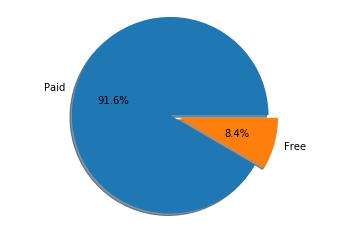

免费/付费课程数：
True     3367
False     310
Name: is_paid, dtype: int64


In [15]:
labels = ['Paid','Free'];
fig, ax = plt.subplots() 
ax.pie(list(df['is_paid'].value_counts()),explode=(0,0.1),labels=labels,
       autopct='%1.1f%%',shadow=True)
ax.axis('equal'); plt.show()
print('免费/付费课程数：'); print(df['is_paid'].value_counts())

可以看到，大部分都是付费课程，免费课程占10%不到。

### 课程数随时间的变化<a name="subparagraph2"></a>

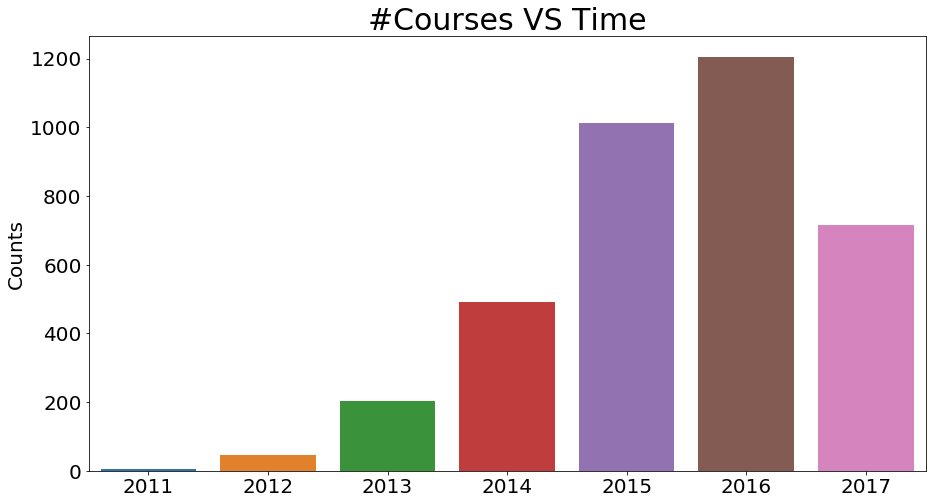

In [18]:
df['year'] = [pd.to_datetime(s).year for s in df['published_timestamp']] #添加一列‘发布年份’信息
fig, ax = plt.subplots(1,1,figsize = (15,8))  
sns.catplot(x='year',kind='count',data = df,ax=ax)
ax.set_title('#Courses VS Time', fontsize=30)
ax.set_ylabel('Counts', fontsize=20) 
ax.set_xlabel(''); 
ax.tick_params(axis='both', which='major', labelsize=20)
plt.close(2)

可以看到，从2011年到2016年，Udemy上的课程数量一直在增长，但是在2017年出现明显下降，由于数据提供信息不够，具体原因未知。

### 不同领域的课程分布情况<a name="subparagraph3"></a>

In [19]:
subject = df.groupby(['is_paid', 'subject']).size().reset_index().pivot(columns='is_paid',index='subject',values=0)
subject.columns=['Free','Paid']
subject['Paid Rate(%)']=(100*subject['Paid']/(subject['Paid']+subject['Free'])).map('{:,.2f}'.format).astype('float64')
subject = subject.sort_values(by='Paid')
subject

,Free,Paid,Paid Rate(%)
subject,,,
Graphic Design,35,568,94.20
Musical Instruments,46,634,93.24
Web Development,133,1067,88.92
Business Finance,96,1098,91.96


可以看到，最火的课程来自于Web开发和商业金融领域，二者课程数量相当，音乐乐器和平面设计领域的课程数量只相当于前者数量的一半。与此相反的是，音乐乐器和平面设计领域的付费课程占比要高于Web开发和商业金融领域。各领域课程数的具体分布见下图：

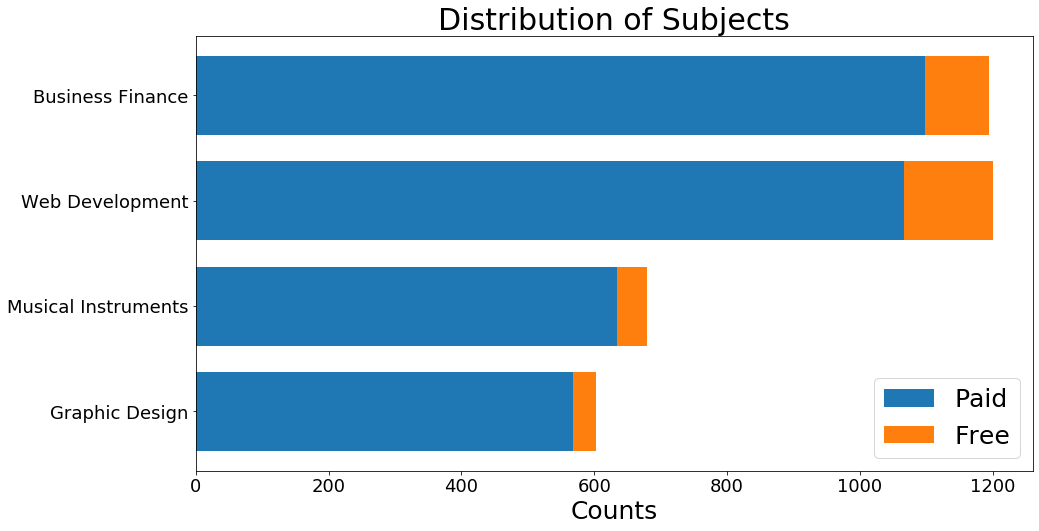

In [20]:
ind = np.arange(4);
fig, ax = plt.subplots(1,1,figsize = (15,8))  
ax.barh(y=list(subject.index), width=list(subject['Paid']),height=0.75)
ax.barh(y=list(subject.index), width=list(subject['Free']),height=0.75,left=list(subject['Paid']))
ax.set_xlabel('Counts',fontsize=25)
ax.set_yticklabels(list(subject.index),fontsize=15)
ax.set_title('Distribution of Subjects',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(('Paid','Free'),fontsize=25)

### 不同难度的课程分布情况<a name="subparagraph4"></a>

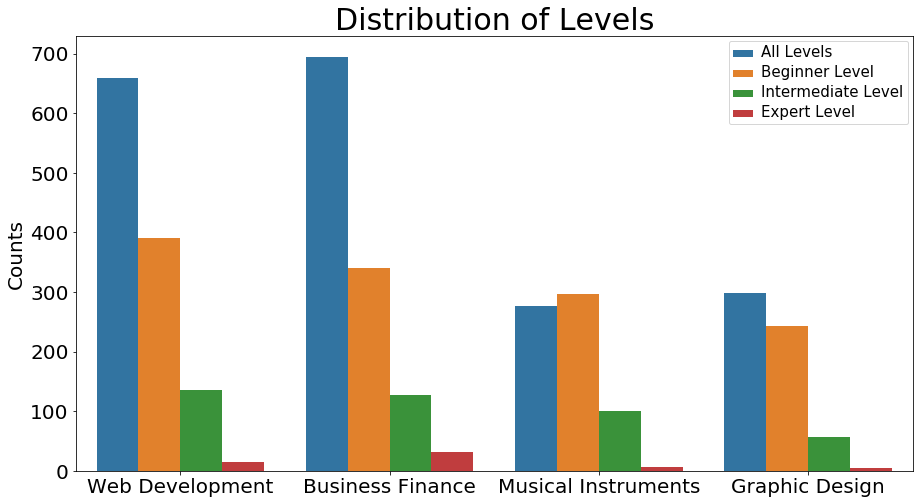

In [21]:
fig, ax = plt.subplots(1,1,figsize = (15,8))  
sns.catplot(x='subject', hue='level',kind='count',data = df,ax=ax,
            hue_order=df['level'].value_counts().index,
            order=df['subject'].value_counts().index)
ax.set_title('Distribution of Levels', fontsize=30)
ax.set_ylabel('Counts', fontsize=20) 
ax.set_xlabel(''); ax.legend(loc=1)
plt.setp(ax.get_legend().get_texts(), fontsize='15') 
ax.tick_params(axis='both', which='major', labelsize=20)
plt.close(2)

可以看到，每个领域内都是All Levels和Beginner Level的课程最多，Expert Level最少，这也是符合常理的，因为开课者会尽量让自己的课程受众更广，从零基础开始教能使整个课程更加系统些。

### 价格分布情况<a name="subparagraph5"></a>

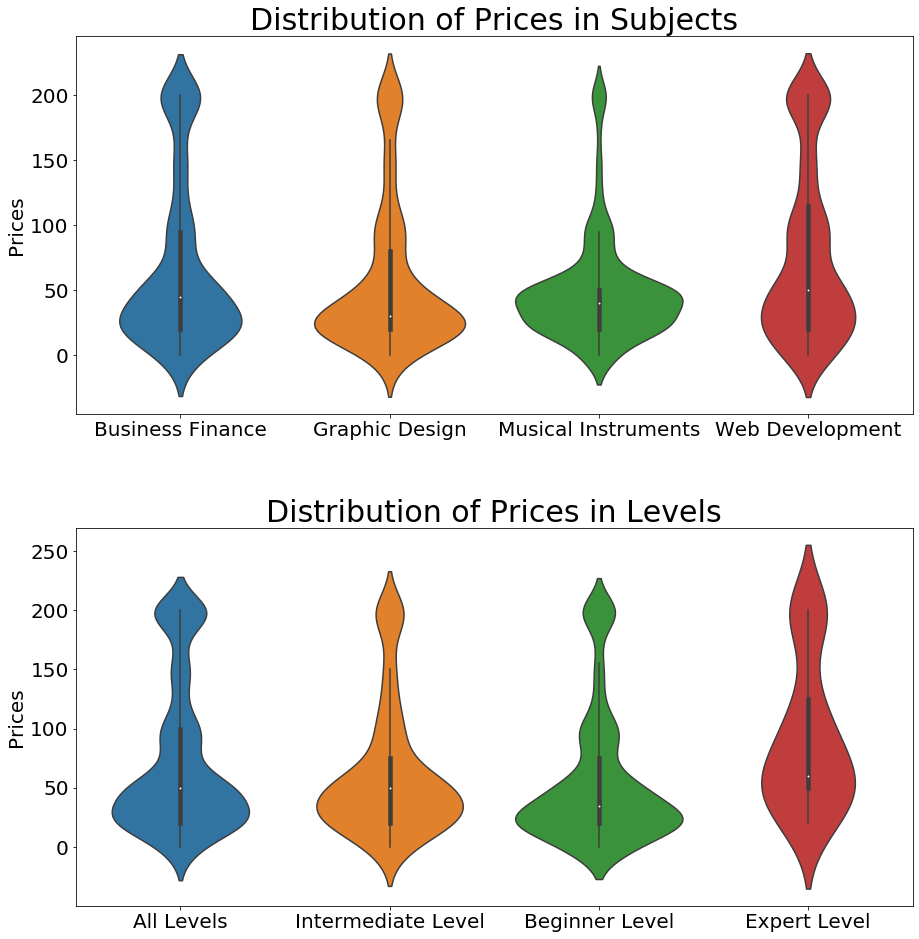

In [22]:
fig, ax = plt.subplots(2,1,figsize = (15,16))  
xx = ['subject','level']; 
title = ['Distribution of Prices in Subjects','Distribution of Prices in Levels']
for i in range(2):
    sns.catplot(x=xx[i],y='price',kind='violin',data=df,ax=ax[i])
    ax[i].set_title(title[i], fontsize=30)
    ax[i].set_ylabel('Prices', fontsize=20) 
    ax[i].set_xlabel('');
    ax[i].tick_params(axis='both', which='major', labelsize=20)
    plt.close(2); 
fig.subplots_adjust(hspace=.3)

上图分别绘制了不同领域的课程的价格分布以及不同难度的课程价格分布情况。可以看到，Udemy的定价策略和课程的领域以及难度基本无关，整体趋势呈现为：0-50美元区间最多，其次是150-200美元区间。

### 其他参数的分布情况<a name="subparagraph6"></a>

最后，我们还剩下num_subscribers(订阅数)、num_reviews(评论数)、num_lectures(课时数)、content_duration(总课程时长)这四个参数的分布情况未分析。先看一下这四个参数的总体情况：

In [23]:
col = ['num_subscribers','num_reviews','num_lectures','content_duration']
df_other = df[col]; df_other.describe()

,num_subscribers,num_reviews,num_lectures,content_duration
count,3677.000000,3677.000000,3677.000000,3677.000000
mean,3198.020125,156.301605,40.119663,43.658961
std,9505.263339,935.575723,50.385854,59.615029
min,0.000000,0.000000,4.000000,8.000000
25%,111.000000,4.000000,15.000000,15.000000
50%,912.000000,18.000000,25.000000,30.000000
75%,2547.000000,67.000000,46.000000,45.000000
max,268923.000000,27445.000000,779.000000,785.000000


可以看到，这四个参数的量级相差挺大，我们可以利用MinMaxScaler()将四个参数进行归一化之后再做比较：

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
col = ['num_subscribers','num_reviews','num_lectures','content_duration']
scaler.fit(df[col])
scaled_fea = scaler.transform(df[col])
df_other = pd.DataFrame(data=scaled_fea,columns=col)
df_other.head()

,num_subscribers,num_reviews,num_lectures,content_duration
0,0.007984,0.000838,0.060645,0.009009
1,0.010382,0.033631,0.348387,0.491634
2,0.008084,0.002696,0.060645,0.021879
3,0.009114,0.000401,0.041290,0.028314
4,0.004745,0.001640,0.028387,0.015444


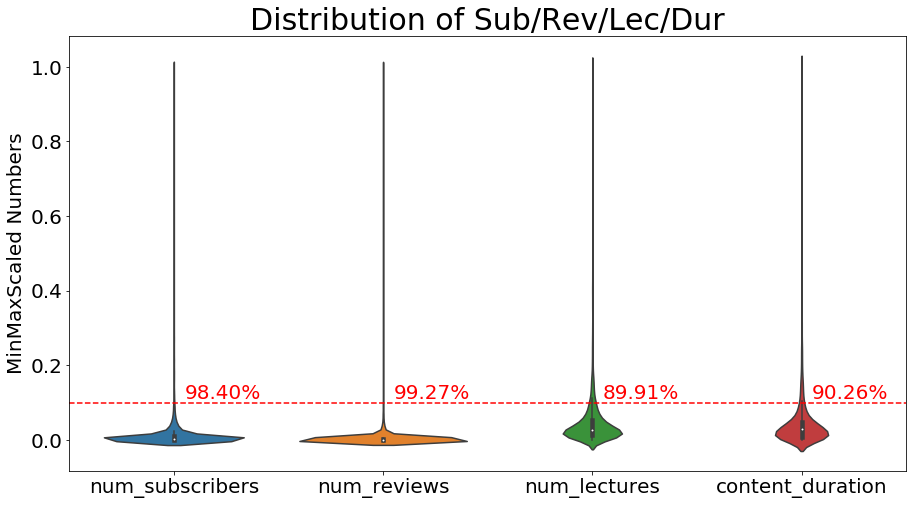

In [25]:
a1 = (100*df_other[df_other['num_subscribers']<0.1].size/df_other.size)
a2 = (100*df_other[df_other['num_reviews']<0.1].size/df_other.size)
a3 = (100*df_other[df_other['num_lectures']<0.1].size/df_other.size)
a4 = (100*df_other[df_other['content_duration']<0.1].size/df_other.size)

fig, ax = plt.subplots(1,1,figsize = (15,8))  
sns.catplot(data=df_other,kind='violin',ax=ax)
ax.set_title('Distribution of Sub/Rev/Lec/Dur', fontsize=30)
ax.axhline(y=0.1, color='r', linestyle='--')
ax.set_ylabel('MinMaxScaled Numbers', fontsize=20) 
ax.tick_params(axis='both', which='major', labelsize=20)
ax.text(0.05,0.11,'{:,.2f}'.format(a1)+'%',fontsize=20,color='red')
ax.text(1.05,0.11,'{:,.2f}'.format(a2)+'%',fontsize=20,color='red')
ax.text(2.05,0.11,'{:,.2f}'.format(a3)+'%',fontsize=20,color='red')
ax.text(3.05,0.11,'{:,.2f}'.format(a4)+'%',fontsize=20,color='red')
plt.close(2);

结果的规律很明显：num_subscribers(订阅数)、num_reviews(评论数)、num_lectures(课时数)、content_duration(总课程时长)这四个参数全部集中在最大值的10%以内分布。

### Top 10<a name="subparagraph7"></a>

这一节，我们来统计一下：最受欢迎的10门课程、最长的10门课程、最贵的10门课程、最赚钱的10门课程。

* 最受欢迎的10门课程 

,Top10 Popular Courses,#Subscribers,#Reviews,Subject
1,Learn HTML5 Programming From Scratch,268923,8629,Web Development
2,Coding for Entrepreneurs Basic,161029,279,Web Development
3,The Web Developer Bootcamp,121584,27445,Web Development
4,The Complete Web Developer Course 2.0,114512,22412,Web Development
5,Build Your First Website in 1 Week with HTML5 and CSS3,120291,5924,Web Development
6,Web Design for Web Developers: Build Beautiful Websites!,98867,6512,Web Development
7,Free Beginner Electric Guitar Lessons,101154,1042,Musical Instruments
8,JavaScript: Understanding the Weird Parts,79612,16976,Web Development
9,Learn Javascript & JQuery From Scratch,84897,2685,Web Development
10,Practical PHP: Master the Basics and Code Dynamic Websites,83737,4598,Web Development


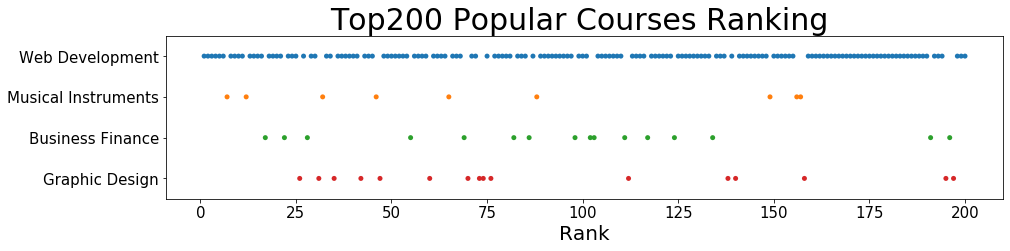

前200受欢迎课程中Web开发占比： 79.50%


In [26]:
#这里赋予订阅数和评论数不同的权重，考虑到有的人只听课而不喜欢评论，将订阅数的权重设为0.7，评论数设为0.3
inde = list((0.7*df['num_subscribers']+0.3*df['num_reviews']).sort_values(ascending=False).index)
top_popular = df.loc[inde,:][['course_title','num_subscribers','num_reviews','subject']]
top_popular.index = np.arange(1, len(top_popular) + 1)
top_popular.columns = ['Top10 Popular Courses', '#Subscribers', '#Reviews','Subject']
with pd.option_context('display.max_colwidth', 100):
    display(top_popular.iloc[:10,:])

#求Top 200 最受欢迎的课程中各个领域的分布
temp = top_popular
temp['rank'] = temp.index
fig, ax = plt.subplots(1,1,figsize = (15,3))  
sns.catplot(y='Subject',x='rank',jitter=False,data=temp.iloc[:200,:],ax=ax)
ax.set_title('Top200 Popular Courses Ranking ', fontsize=30)
ax.set_ylabel('', fontsize=20); ax.set_xlabel('Rank', fontsize=20) 
ax.tick_params(axis='both', which='major', labelsize=15)
plt.close(2);plt.show()

#求Top 200 最受欢迎的课程中Web开发的占比
pop_rate = 100*(temp.iloc[:200,:]['Subject']=='Web Development').sum()/200
print('前200受欢迎课程中Web开发占比：','{:,.2f}'.format(pop_rate)+'%')

由此可见，Web开发在Udemy上非常火爆，前十受欢迎的课程里面有9门课程都属于Web开发领域,前200受欢迎课程中Web开发占了79.5%.

* 最长的10门课

,Top10 Highest Duration Courses,#Hours,#Lectures,Subject,Level
1,The Complete Figure Drawing Course HD,785.0,225,Graphic Design,Beginner Level
2,The Complete Web Development Course - Build 15 Projects,765.0,384,Web Development,All Levels
3,Financial Management - A Complete Study,715.0,527,Business Finance,All Levels
4,TRADER BOT: Introdução à Linguagem MQL5,700.0,33,Business Finance,All Levels
5,Anatomy for Figure Drawing: Mastering the Human Figure,685.0,65,Graphic Design,All Levels
6,Modern E-Commerce Store In php & mysqli With Bootstrap,665.0,358,Web Development,All Levels
7,Advanced Accounting A Complete Study for CA / CMA / CFA / CS,620.0,462,Business Finance,All Levels
8,Discover How to Draw and paint Comics,620.0,85,Graphic Design,All Levels
9,Become a Professional Web Developer | Version 3.0,600.0,454,Web Development,All Levels
10,Code & Grow Rich: Earn More As An Entrepreneur Or Developer,570.0,491,Web Development,All Levels


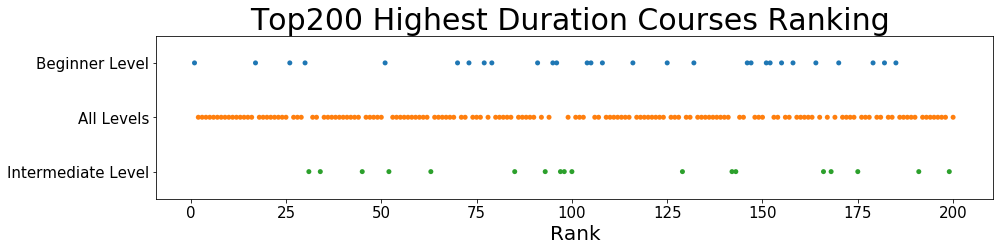

前200受欢迎课程中All Levels难度的占比： 76.50%


In [27]:
#求Top 10 最长的课程
top_long = df.sort_values(by='content_duration',ascending=False)[['course_title','content_duration','num_lectures','subject','level']]
top_long.index = np.arange(1, len(top_long) + 1)
top_long.columns = ['Top10 Highest Duration Courses', '#Hours', '#Lectures','Subject','Level']
with pd.option_context('display.max_colwidth', 100):
    display(top_long.iloc[:10,:])

#求Top 200 最长的课程中，各个难度的分布  
temp = top_long
temp['rank'] = temp.index
fig, ax = plt.subplots(1,1,figsize = (15,3))  
sns.catplot(y='Level',x='rank',jitter=False,data=temp.iloc[:200,:],ax=ax)
ax.set_title('Top200 Highest Duration Courses Ranking ', fontsize=30)
ax.set_ylabel('', fontsize=20); ax.set_xlabel('Rank', fontsize=20) 
ax.tick_params(axis='both', which='major', labelsize=15)
plt.close(2);plt.show()

#求Top 200 最长的课程中，All Levels难度的占比 
long_rate = 100*(temp.iloc[:200,:]['Level']=='All Levels').sum()/200
print('前200受欢迎课程中All Levels难度的占比：','{:,.2f}'.format(long_rate)+'%')

可以看到，总时长最长的课程前10里面有9个的难度都是All Levels,最长的达到了785个小时。另外，在前200中，并没有Expert难度的课程，这也是符合预期的。最后，在前200中All Levels难度的课程占比最高，达到了76.5%

* 最贵的10门课程

In [28]:
top_expen = df.sort_values(by='price',ascending=False)[['course_title','price','subject']].iloc[:10,:]
top_expen.index = np.arange(1, len(top_expen) + 1)
top_expen.columns = ['Top10 Expensive Courses', 'Price','Subject']
with pd.option_context('display.max_colwidth', 100):
    display(top_expen)
print('定价为200的课程数： ',(df['price']==200).sum())

,Top10 Expensive Courses,Price,Subject
1,Ultimate Investment Banking Course,200,Business Finance
2,Complete Guide to Front-End Web Development and Design,200,Web Development
3,Code & Grow Rich: Earn More As An Entrepreneur Or Developer,200,Web Development
4,Contango VXX - ETF Options Trading - Double Your Investment,200,Business Finance
5,Javascript Specialist,200,Web Development
6,Bitcoin & Ethereum Course (2 Course Bundle),200,Business Finance
7,"Laravel, the complete guide with real world projects",200,Web Development
8,VueJS V1 Introduction to VueJS JavaScript Framework,200,Web Development
9,Win 90% of Trades; Quantitative Investments Models in Excel,200,Business Finance
10,Professional Trading With Institutional Supply & Demand,200,Business Finance


定价为200的课程数：  295


可以看到，事实上Udemy网站中最高定价都是200，且总共有295个课程定价为200.

* 最赚钱的10门课

,Top10 Profitable Courses,Profit,Price,Subscribers,Subject,Pop_rank
1,The Web Developer Bootcamp,24316800,200,121584,Web Development,3
2,The Complete Web Developer Course 2.0,22902400,200,114512,Web Development,4
3,Pianoforall - Incredible New Way To Learn Piano & Keyboard,15099800,200,75499,Musical Instruments,12
4,Angular 4 (formerly Angular 2) - The Complete Guide,14018770,190,73783,Web Development,11
5,JavaScript: Understanding the Weird Parts,13932100,175,79612,Web Development,8
6,Learn and Understand NodeJS,11350560,195,58208,Web Development,20
7,The Complete HTML & CSS Course - From Novice To Professional,11197290,195,57422,Web Development,23
8,Complete PHP Course With Bootstrap3 CMS System & Admin Panel,10789740,195,55332,Web Development,25
9,Learn and Understand AngularJS,10388175,175,59361,Web Development,19
10,Modern React with Redux,9146700,180,50815,Web Development,24


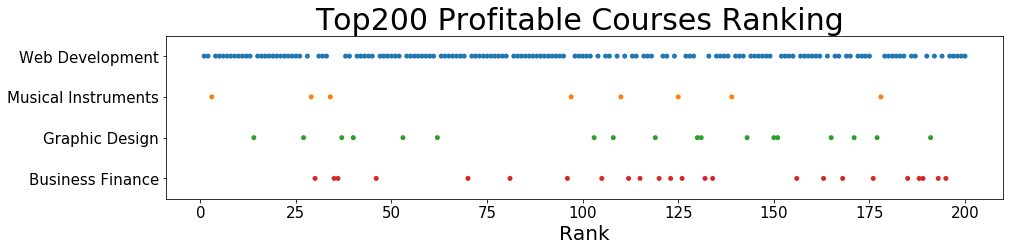

前200最赚钱的课程中Web开发占比： 75.00%


In [29]:
 #求Top 10 最赚钱的课程
inde = (df['price']*df['num_subscribers']).sort_values(ascending=False).index
top_profit = df.loc[inde,:][['course_title','price','num_subscribers','subject']].iloc[:200,:]
top_profit.index = np.arange(1, len(top_profit) + 1)
top_profit['profit'] = top_profit['price']*top_profit['num_subscribers']
top_profit.columns = ['Top10 Profitable Courses','Price','Subscribers','Subject', 'Profit']
pop_rank = np.array([top_popular[top_popular['Top10 Popular Courses']==x].index.values[0] for x in top_profit.iloc[:,0]])
top_profit['Pop_rank']=pop_rank  #这两行语句是加入每个课程对应的受欢迎程度排名
with pd.option_context('display.max_colwidth', 100):
    display(top_profit.iloc[:10,[0,4,1,2,3,5]])
    
#求Top 200 最赚钱的课程中，各个领域的分布  
temp = top_profit
temp['rank'] = temp.index
fig, ax = plt.subplots(1,1,figsize = (15,3))  
sns.catplot(y='Subject',x='rank',jitter=False,data=temp.iloc[:200,:],ax=ax)
ax.set_title('Top200 Profitable Courses Ranking ', fontsize=30)
ax.set_ylabel('', fontsize=20); ax.set_xlabel('Rank', fontsize=20) 
ax.tick_params(axis='both', which='major', labelsize=15)
plt.close(2);plt.show()

#求Top 200 最赚钱的课程中Web开发的占比 
profit_rate = 100*(temp.iloc[:200,:]['Subject']=='Web Development').sum()/200
print('前200最赚钱的课程中Web开发占比：','{:,.2f}'.format(profit_rate)+'%')

由于Web开发的火爆程度，最赚钱的10门课程里面有9门都属于Web开发。上表最后一列是该课程对应的受欢迎程度排名，可以看出最赚钱的课程的受欢迎程度也名列前茅（前25）。最后，在前200最赚钱的课程中Web开发占比高达75%.

## 课程订阅数预测<a name="paragraph3"></a>

这一部分，我们将利用多种机器学习的方法对一个新推出的课程最终获得的订阅数进行预测。由于课程推出后会持续收到订阅数，但是随着时间的推移，新增订阅数会越来越少。假定一个课程推出2年内收到的订阅数和最终收到的订阅数的差别可以忽略，考虑到表中所有课程最晚的发布时间为2017年，因此可以认为表中的课程订阅数就是最终订阅数。

### 特征工程<a name="subparagraph1"></a>

* 类别特征向量化

In [30]:
#在用学习器进行学习之前，我们先将表中的类别数据转换成数值数据（one-hot方法）：
df1=df[['course_id','is_paid','price','num_subscribers','num_lectures','level','content_duration','subject']]
one_hot = pd.get_dummies(df1[['is_paid','level','subject']],drop_first=True)
df_onehot = df1.merge(one_hot, how='outer', left_index=True, right_index=True).iloc[:,[1,2,3,4,6,9,10,11,12,13,14]] 
df_onehot.head()

,is_paid_x,price,num_subscribers,num_lectures,content_duration,level_Beginner Level,level_Expert Level,level_Intermediate Level,subject_Graphic Design,subject_Musical Instruments,subject_Web Development
0,True,200,2147,51,15.0,0,0,0,0,0,0
1,True,75,2792,274,390.0,0,0,0,0,0,0
2,True,45,2174,51,25.0,0,0,1,0,0,0
3,True,95,2451,36,30.0,0,0,0,0,0,0
4,True,200,1276,26,20.0,0,0,1,0,0,0


* 提取特征

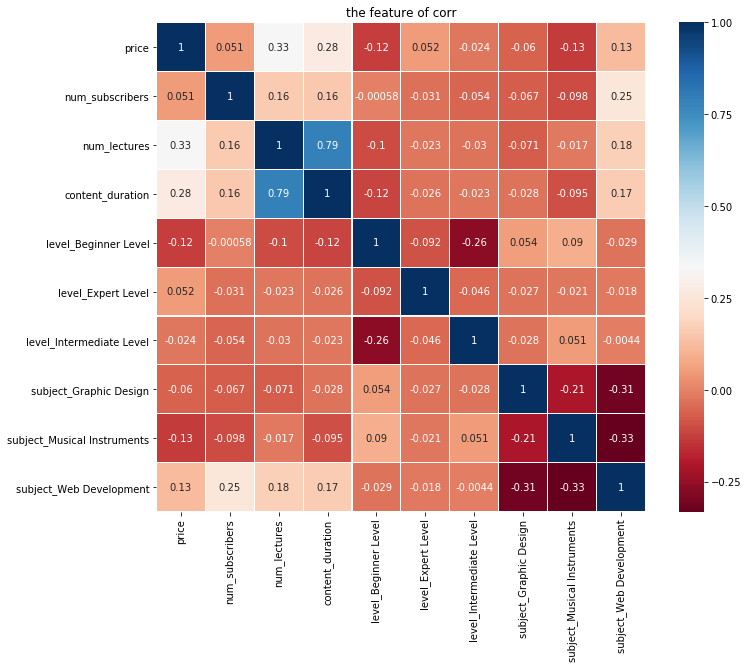

In [31]:
#画出各个特征之间的热力图
plt.figure(figsize=(12, 9))
ax = sns.heatmap(df_onehot.iloc[:,1:].corr(), linewidths=0.1, vmax=1.0, square=True,
            cmap=sns.color_palette('RdBu', n_colors=256),
            linecolor='white', annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('the feature of corr')
plt.show()

可以看到，在第二行中num_subscribers(订阅数)与其他特征的相关系数的绝对值全部小于0.25，这说明这些特征是无关特征。为了验证这一点，我们用不同的学习器对数据进行学习，最后期望学习的结果和真实结果相差很大。注意到特征之间最大关联为0.79，不是太强，于是我们保留所有特征，接下来开始用学习器进行学习。

### 10折交叉验证之Bagging<a name="subparagraph2"></a>

In [32]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

start_time = time.monotonic();
X = df_onehot.drop('num_subscribers',axis=1); Y = df_onehot.iloc[:,2]
kfold = model_selection.KFold(n_splits=10, random_state=101)
cart = DecisionTreeRegressor()
model_bag = BaggingRegressor(base_estimator=cart, n_estimators=100, random_state=101)#100个基学习器
bag_score1 = cross_val_score(model_bag, X, Y, cv=kfold, scoring='neg_mean_squared_error')
bag_score2 = cross_val_score(model_bag, X, Y, cv=kfold, scoring='r2')
end_time = time.monotonic()

print('10折交叉验证之Bagging的MSE（95%%置信区间）: %0.6f (+/- %0.6f)' % (-bag_score1.mean(), bag_score1.std() * 2))
print('10折交叉验证之Bagging的r2（95%%置信区间）: %0.6f (+/- %0.6f)' % (bag_score2.mean(), bag_score2.std() * 2))
print('100个基学习器运行时间：',timedelta(seconds=end_time - start_time))

10折交叉验证之Bagging的MSE（95%置信区间）: 96055146.128643 (+/- 208798843.405733)
10折交叉验证之Bagging的r2（95%置信区间）: -1.042803 (+/- 3.850074)
100个基学习器运行时间： 0:00:19.860000


### 10折交叉验证之Adaboost<a name="subparagraph3"></a>

In [33]:
from sklearn.ensemble import AdaBoostRegressor

start_time = time.monotonic();
X = df_onehot.drop('num_subscribers',axis=1); Y = df_onehot.iloc[:,2]
kfold = model_selection.KFold(n_splits=10, random_state=101)
model_ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=1),n_estimators=100,random_state=101)
#100个基学习器，树的最大深度设为1是为了降低学习器的方差
adb_score1 = cross_val_score(model_ada, X, Y, cv=kfold, scoring='neg_mean_squared_error')
adb_score2 = cross_val_score(model_ada, X, Y, cv=kfold, scoring='r2')
end_time = time.monotonic()

print('10折交叉验证之Adaboost的MSE（95%%置信区间）: %0.6f (+/- %0.6f)' % (-adb_score1.mean(), adb_score1.std() * 2))
print('10折交叉验证之Adaboost的r2（95%%置信区间）: %0.6f (+/- %0.6f)' % (adb_score2.mean(), adb_score2.std() * 2))
print('100个基学习器运行时间：',timedelta(seconds=end_time - start_time))

10折交叉验证之Adaboost的MSE（95%置信区间）: 92879653.888686 (+/- 212232870.201933)
10折交叉验证之Adaboost的r2（95%置信区间）: -1.352641 (+/- 5.898236)
100个基学习器运行时间： 0:00:02.016000


### 10折交叉验证之随机森林<a name="subparagraph4"></a>

In [34]:
from sklearn.ensemble import RandomForestRegressor

start_time = time.monotonic();
X = df_onehot.drop('num_subscribers',axis=1); Y = df_onehot.iloc[:,2]
kfold = model_selection.KFold(n_splits=10, random_state=101)
model_rf = RandomForestRegressor(n_estimators=100, max_features='log2')
#100个基学习器，每次随机选择log2 (10)约等于3个特征来进行分割
rf_score1 = cross_val_score(model_rf, X, Y, cv=kfold, scoring='neg_mean_squared_error')
rf_score2 = cross_val_score(model_rf, X, Y, cv=kfold, scoring='r2')
end_time = time.monotonic()

print('10折交叉验证之随机森林的MSE（95%%置信区间）: %0.6f (+/- %0.6f)' % (-rf_score1.mean(), rf_score1.std() * 2))
print('10折交叉验证之随机森林的r2（95%%置信区间）: %0.6f (+/- %0.6f)' % (rf_score2.mean(), rf_score2.std() * 2))
print('100个基学习器运行时间：',timedelta(seconds=end_time - start_time))

10折交叉验证之随机森林的MSE（95%置信区间）: 89357823.754507 (+/- 194933820.667633)
10折交叉验证之随机森林的r2（95%置信区间）: -0.554965 (+/- 2.033042)
100个基学习器运行时间： 0:00:09.078000


### 10折交叉验证之提升树<a name="subparagraph5"></a>

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

start_time = time.monotonic();
X = df_onehot.drop('num_subscribers',axis=1); Y = df_onehot.iloc[:,2]
kfold = model_selection.KFold(n_splits=10, random_state=101)
model_gb = GradientBoostingRegressor(n_estimators=100,loss='ls')#100个基学习器，采用least squares损失函数
gb_score1 = cross_val_score(model_gb, X, Y, cv=kfold, scoring='neg_mean_squared_error')
gb_score2 = cross_val_score(model_gb, X, Y, cv=kfold, scoring='r2')
end_time = time.monotonic()

print('10折交叉验证之提升树的MSE（95%%置信区间）: %0.6f (+/- %0.6f)' % (-gb_score1.mean(), gb_score1.std() * 2))
print('10折交叉验证之提升树的r2（95%%置信区间）: %0.6f (+/- %0.6f)' % (gb_score2.mean(), gb_score2.std() * 2))
print('100个基学习器运行时间：',timedelta(seconds=end_time - start_time))

10折交叉验证之提升树的MSE（95%置信区间）: 85819581.653564 (+/- 197978659.339327)
10折交叉验证之提升树的r2（95%置信区间）: -0.773995 (+/- 3.787536)
100个基学习器运行时间： 0:00:02.688000


### 10折交叉验证之线性回归<a name="subparagraph6"></a>

In [36]:
from sklearn.linear_model import LinearRegression

start_time = time.monotonic();
X = df_onehot.drop('num_subscribers',axis=1); Y = df_onehot.iloc[:,2]
kfold = model_selection.KFold(n_splits=10, random_state=101)
model_lr = LinearRegression() #不是集成学习，只有1个学习器
gb_score1 = cross_val_score(model_lr, X, Y, cv=kfold, scoring='neg_mean_squared_error')
gb_score2 = cross_val_score(model_lr, X, Y, cv=kfold, scoring='r2')
end_time = time.monotonic()

print('10折交叉验证之线性回归的MSE（95%%置信区间）: %0.6f (+/- %0.6f)' % (-gb_score1.mean(), gb_score1.std() * 2))
print('10折交叉验证之线性回归的r2（95%%置信区间）: %0.6f (+/- %0.6f)' % (gb_score2.mean(), gb_score2.std() * 2))
print('运行时间：',timedelta(seconds=end_time - start_time))

10折交叉验证之线性回归的MSE（95%置信区间）: 79932786.793465 (+/- 206945568.851873)
10折交叉验证之线性回归的r2（95%置信区间）: -0.348287 (+/- 2.114246)
运行时间： 0:00:00.234000


我们可以看到上述所有学习器的效果都非常差，完全偏离真实值。这恰恰说明**在Udemy上一个课程的订阅人数和这个课程的难度，价格，课时数，总时长，所属领域还有是否付费无关**，真正与订阅数有关的可能是该课程与教师的曝光度，教师的讲课技巧，某学科领域的突然兴起等因素，而这需要更多的数据信息才能确定。

### 结论<a name="paragraph4"></a>

主要结论：
    * 该表格抽取了Udemy网站是来自四个不同领域：Web开发、商业金融、音乐乐器和平面设计的课程，每个领域都涵盖了四个不同难度的课程（适合所有人、适合新手、中等级别和专家级别），这些课程中91.6%都是付费课程。
    * Udemy的定价规则为0-200美元之间，最终开课者的定价结果呈两级分布：0-50美元和150-200美元区间的课程最多。
    * 订阅数、评论数、课时数、总课程时长这四个参数全部集中在最大值的10%以内分布。
    * Udemy上最受欢迎的课程来自于Web开发领域,前200受欢迎课程中Web开发占了79.5%，同时该领域的课程也是最赚钱的，前200赚钱课程中Web开发占了75%.
    * Udemy上一个课程的订阅人数和这个课程的难度，价格，课时数，总时长，所属领域还有是否付费无关。